<a href="https://colab.research.google.com/github/matthiaszeller/dl-project/blob/main/FINALNOTEBOOK__Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

# Dataset

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

--2021-04-29 12:21:25--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-29 12:21:25--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [            <=>     ]  33.20M  6.42MB/s    in 15s     

2021-04-29 12:21:40 (2.29 MB/s) - ‘MNIST.tar.gz’ saved [34813078]



In [3]:
!tar -xf MNIST.tar.gz

In [4]:
!ls MNIST/processed/

test.pt  training.pt


In [5]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [6]:
train_input , train_target , train_classes , test_input , test_target , test_classes = generate_pair_sets(1000)

In [7]:
train_dataset = TensorDataset(train_input,train_target , train_classes)
test_dataset = TensorDataset(test_input,test_target , test_classes)

# model

## FCNN

In [8]:
class FCNN_1LAYER(nn.Module):
    def __init__(self , **kwargs):
        super(FCNN_1LAYER, self).__init__()

        nb_n = kwargs["nodes_nb"]

        self.input = nn.Linear(2*14*14, nb_n)
        self.fc1 = nn.Linear(nb_n, 1)
        

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.input(x) )
        x = self.fc1(x)
        
        return torch.sigmoid(x)

class FCNN_2LAYER(nn.Module):
    def __init__(self , **kwargs):
        super(FCNN_2LAYER, self).__init__()


        self.input = nn.Linear(2*14*14, 300)
        self.fc1 = nn.Linear(300, 50)
        self.fc2 = nn.Linear(50, 1)
        

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.input(x) )
        x = torch.relu( self.fc1(x) )
        x = self.fc2(x)
        
        return torch.sigmoid(x)

class FCNN_3LAYER(nn.Module):
    def __init__(self , **kwargs):
        super(FCNN_3LAYER, self).__init__()


        self.input = nn.Linear(2*14*14, 300)
        self.fc1 = nn.Linear(300, 150)
        self.fc2 = nn.Linear(150, 50)
        self.fc3 = nn.Linear(50, 1)

        

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.input(x) )
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = self.fc3(x)
        
        return torch.sigmoid(x)

class FCNN_4LAYER(nn.Module):
    def __init__(self , **kwargs):
        super(FCNN_4LAYER, self).__init__()


        self.input = nn.Linear(2*14*14, 300)
        self.fc1 = nn.Linear(300, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 1)

        

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.input(x) )
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = torch.relu( self.fc3(x) )
        x = self.fc4(x)
        
        return torch.sigmoid(x)



class FCNN_image_specific(nn.Module):
    def __init__(self , **kwargs):
        super(FCNN_image_specific, self).__init__()

        nb_n = kwargs["nodes_nb"]

        self.input = nn.Linear(14*14, nb_n)
        self.fc1R = nn.Linear(nb_n, 10)
        self.fc1L = nn.Linear(nb_n, 10)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)

        x_l = torch.relu( self.input( nn.Flatten(1)(x_l) ) )
        x_l = torch.relu( self.fc1L( x_l) ) 

        x_r = torch.relu( self.input(nn.Flatten(1)(x_r)) )
        x_r = torch.relu( self.fc1R(x_r) ) 

        x = self.fc2(torch.cat([x_l , x_r], 1))
        return torch.sigmoid(x)

## WS

In [9]:
class WS_FCNN_image_specific(nn.Module):
    def __init__(self , **kwargs):
        super(WS_FCNN_image_specific, self).__init__()

        nb_n = kwargs["nodes_nb"]

        self.input = nn.Linear(14*14, nb_n)
        self.fc1 = nn.Linear(nb_n, 10)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)

        x_l = torch.relu( self.input( nn.Flatten(1)(x_l) ) )
        x_l = torch.relu( self.fc1( x_l) ) 

        x_r = torch.relu( self.input(nn.Flatten(1)(x_r)) )
        x_r = torch.relu( self.fc1(x_r) ) 

        x = self.fc2(torch.cat([x_l , x_r], 1))
        return torch.sigmoid(x)

class WS_CNN_image_specific(nn.Module):
    def __init__(self , **kwargs):
        super(WS_CNN_image_specific, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 5, kernel_size=3)

        self.fc1 = nn.Linear(500, 10)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):

        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)

        x_l = torch.relu(self.conv1(x_l))
        x_l = torch.relu(self.conv2(x_l))
        x_l = nn.Flatten(1)(x_l)
        #print(x_l.shape)
        x_l = torch.relu( self.fc1(x_l) )

        x_r = torch.relu(self.conv1(x_r))
        x_r = torch.relu(self.conv2(x_r))
        x_r = nn.Flatten(1)(x_r)
        x_r = torch.relu( self.fc1(x_r) )

        x = self.fc2(torch.cat([x_l , x_r], 1))

        return torch.sigmoid(x)

## AL 

In [61]:
class AL_WS_FCNN_image_specific(nn.Module):
    def __init__(self , **kwargs):
        super(AL_WS_FCNN_image_specific, self).__init__()

        nb_n = kwargs["nodes_nb"]

        self.input = nn.Linear(14*14, nb_n)
        self.fc1 = nn.Linear(nb_n, 10)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)

        x_l = torch.relu( self.input( nn.Flatten(1)(x_l) ) )
        x_l = torch.relu( self.fc1( x_l) ) 

        x_r = torch.relu( self.input(nn.Flatten(1)(x_r)) )
        x_r = torch.relu( self.fc1(x_r) ) 

        x = self.fc2(torch.cat([x_l , x_r], 1))

        return torch.sigmoid(x) , F.log_softmax (x_l) , F.log_softmax (x_r)

# Train utils

In [11]:
def custom_loss(output, target, classes, lambda_=1.0):
  """
  Custom loss for network with auxiliary losses. The total loss is a combination
  of the loss of the main task (binary cross entropy) and the negative log likelihood
  for the two auxiliary tasks. Importance of auxiliary losses is controlled by
  the `lambda_` hyperparameter.
  """
  main, im1, im2 = output

  main_loss = F.binary_cross_entropy(main.flatten(), target)
  aux_loss_1 = F.nll_loss(im1, classes[:, 0])
  aux_loss_2 = F.nll_loss(im2, classes[:, 1])

  return main_loss + lambda_ * (aux_loss_1 + aux_loss_2)

In [12]:
def handle_loss(criterion_):
  
  """
  Handle the fact that the network with auxiliary loss has three-item tuple output,
  which needs to be treated separately to compute the loss and the accuracy.
  """
  if criterion_ is F.binary_cross_entropy:
    internal_criterion = lambda output, target, _: criterion_(output.flatten(), target)
    compute_acc = lambda output, target: (target == torch.round(output.flatten()) ).float()
  else:
    internal_criterion = criterion_
    compute_acc = lambda output, target: (target == torch.round(output[0].flatten()) ).float()
    
  return internal_criterion, compute_acc

In [13]:
def train_epoch(network_ , optimizer_ , criterion_ = F.binary_cross_entropy ):
  
  internal_criterion, compute_acc = handle_loss(criterion_)

  loss_tot = []
  acc_tot = []
  network_.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer_.zero_grad()
    output = network_(data)
    loss = internal_criterion(output, target.to(torch.float32), classes)
    loss.backward()
    optimizer_.step()

    loss_tot.append(loss.item())
    acc_tot.append( compute_acc(output, target) )
    
  return torch.FloatTensor(loss_tot).mean().item() , torch.cat(acc_tot).mean().item()

In [14]:
def test(network_ , criterion_ = F.binary_cross_entropy):
  
  internal_criterion, compute_acc = handle_loss(criterion_)

  network_.eval()
  test_loss = []
  acc = []

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network_(data)
      loss = internal_criterion(output, target.to(torch.float32), classes)
      test_loss.append( loss.item() )
      acc.append( compute_acc(output, target) )

  
  return torch.FloatTensor(test_loss).mean().item() , torch.cat(acc).mean().item()

In [15]:
def train(network_ , optimizer_ , criterion_ = F.binary_cross_entropy ,epoch_nb = 30,   debug_ = True):

  tot_train_loss = []
  tot_train_acc = []
  tot_test_loss = []
  tot_test_acc = []


  for epoch in range(epoch_nb):

    train_loss , train_acc = train_epoch(network_ , optimizer_ , criterion_)
    test_loss , test_acc = test(network_ , criterion_)

    tot_train_loss.append(train_loss)
    tot_train_acc.append(train_acc)
    tot_test_loss.append(test_loss)
    tot_test_acc.append(test_acc)

    if(debug_):
      print(epoch, train_loss , train_acc , test_loss , test_acc)

  return tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc

# Stat train utils

In [16]:
def train_multiple_runs( network_class , runs  , epoch  , lr_  , criterion_ , **kwargs):
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = [],[],[],[]
  
  for i in range(runs):
    n = network_class(**kwargs)
    optimizer = optim.Adam(n.parameters(), lr=lr_)
    criterion = criterion_

    tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(n , optimizer , criterion , epoch , debug_ = False)
    all_train_loss.append(tot_train_loss)
    all_train_acc.append(tot_train_acc)
    all_test_loss.append(tot_test_loss)
    all_test_acc.append(tot_test_acc)

  return all_train_loss , all_train_acc , all_test_loss , all_test_acc

In [17]:
import numpy as np
def plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc , color = ''):
  trl_mean = np.array(all_train_loss).mean(axis = 0)
  tra_mean = np.array(all_train_acc).mean(axis = 0)
  tel_mean = np.array(all_test_loss).mean(axis = 0)
  tea_mean = np.array(all_test_acc).mean(axis = 0)

  trl_std = np.array(all_train_loss).std(axis = 0)
  tra_std = np.array(all_train_acc).std(axis = 0)
  tel_std = np.array(all_test_loss).std(axis = 0)
  tea_std = np.array(all_test_acc).std(axis = 0)

  epochs = range(1, len(tea_std)+1 )

  early_stopping = np.argmin( tel_mean )
  print(f"at epoch {early_stopping} mean test acc : { tea_mean[early_stopping] }")
  print(f"mean last test acc : { tea_mean [-1] }")

  temp = [ [trl_mean , trl_std , 'g' , 'trl'] ,
          [tel_mean , tel_std  , 'b' , 'tel'] ,
          [tra_mean , tra_std  , 'r' , 'tra'] ,
          [tea_mean , tea_std  , 'y' , 'tea'] ]

  if color != '':
    plt.plot( epochs , tea_mean , c=color )
    plt.fill_between(epochs, tea_mean-tea_std, tea_mean+tea_std ,alpha=0.1 , color=color )
    #plt.ylim((-0.1,1.1))
    return

  for g in temp : 
    plt.plot( epochs , g[0] , c=g[2] , label = g[3])
    plt.fill_between(epochs, g[0]-g[1], g[0]+g[1] ,alpha=0.3 , color=g[2] )

  plt.legend()
  plt.ylim((-0.1,1.1))
  plt.show()

# Testing

In [76]:
def custom_loss1(output, target, classes):
  """
  Custom loss for network with auxiliary losses. The total loss is a combination
  of the loss of the main task (binary cross entropy) and the negative log likelihood
  for the two auxiliary tasks. Importance of auxiliary losses is controlled by
  the `lambda_` hyperparameter.
  """
  main, im1, im2 = output
  
  im1_score = torch.argmax(im1,dim=1)
  im2_score = torch.argmax(im2,dim=1)

  aux_loss_1 = F.nll_loss(im1, classes[:, 0])
  aux_loss_2 = F.nll_loss(im2, classes[:, 1])

  main_loss = F.binary_cross_entropy(main.flatten(), target) 
  extra_loss = F.binary_cross_entropy((im1_score<=im2_score).float().flatten(), target)

  #print(main_loss ,  extra_loss/50 , aux_loss_1 , aux_loss_2 )

  return main_loss#*5 + extra_loss/50 + 1. * (aux_loss_1 + aux_loss_2)

In [19]:
# BATCH SIZE !
train_dataloader = DataLoader(train_dataset , batch_size=20)
test_dataloader  = DataLoader(test_dataset  , batch_size=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


at epoch 3 mean test acc : 0.8180000185966492
mean last test acc : 0.8339999914169312


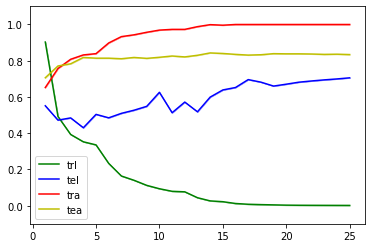

In [78]:
all_train_loss , all_train_acc , all_test_loss , all_test_acc = train_multiple_runs( AL_WS_FCNN_image_specific ,
                                                                                     runs = 1 ,
                                                                                     epoch = 25 ,
                                                                                     lr_= 0.0005 ,
                                                                                     criterion_ = custom_loss1,
                                                                                     nodes_nb = 500 )
plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc )

In [ ]:
for lr in [0.00005 , 0.00007 , 0.0001 , 0.00015 , 0.0002 , 0.00025 , 0.0003 , 0.0004]:
  print(f'at LR = {lr}')
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = train_multiple_runs( WS_CNN_image_specific ,
                                                                                     runs = 1 ,
                                                                                     epoch = 25 ,
                                                                                     lr_= lr ,
                                                                                     criterion_ = F.binary_cross_entropy,
                                                                                     nodes_nb = _ )
  plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc)

In [22]:
###########################################################################
######################### AL GRAPH ########################################
###########################################################################






--- configuration : [1000, 0.0005, 'r', <class '__main__.WS_FCNN_image_specific'>]
at epoch 3 mean test acc : 0.7998000025749207
mean last test acc : 0.8442000031471253
--- configuration : [1000, 0.0005, 'black', <class '__main__.FCNN_image_specific'>]
at epoch 3 mean test acc : 0.7589999914169312
mean last test acc : 0.8167999982833862
--- configuration : ['', 0.0015, 'b', <class '__main__.WS_CNN_image_specific'>]
at epoch 2 mean test acc : 0.7740000009536743
mean last test acc : 0.8157999992370606


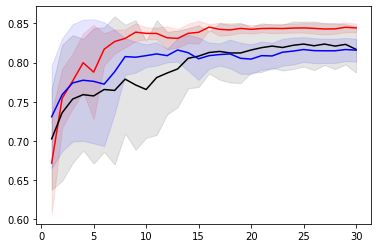

In [23]:
###########################################################################
######################### WS GRAPH ########################################
###########################################################################

stats = [[1000  ,0.0005  ,'r' , WS_FCNN_image_specific] ,
         [1000  ,0.0005  ,'black' , FCNN_image_specific   ] ,
         [ _    ,0.0015  ,'b' , WS_CNN_image_specific ] ,
         ]

for el in stats:
  print(f'--- configuration : {el}')
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = train_multiple_runs( el[3] ,
                                                                                     runs = 5 ,
                                                                                     epoch = 30 ,
                                                                                     lr_= el[1] ,
                                                                                     criterion_ = F.binary_cross_entropy,
                                                                                     nodes_nb = el[0] )
  plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc , color = el[2])

--- configuration : [200, 0.001, 'r', <class '__main__.FCNN_image_specific'>]
at epoch 2 mean test acc : 0.8001999974250793
mean last test acc : 0.8352000117301941
--- configuration : [500, 0.001, 'r', <class '__main__.FCNN_image_specific'>]
at epoch 4 mean test acc : 0.7629999995231629
mean last test acc : 0.8312000036239624
--- configuration : [700, 0.0007, 'r', <class '__main__.FCNN_image_specific'>]
at epoch 3 mean test acc : 0.7638000011444092
mean last test acc : 0.8357999920845032
--- configuration : [1000, 0.0005, 'r', <class '__main__.FCNN_image_specific'>]
at epoch 2 mean test acc : 0.7902000069618225
mean last test acc : 0.8273999929428101
--- configuration : [1500, 0.0002, 'r', <class '__main__.FCNN_image_specific'>]
at epoch 3 mean test acc : 0.7885999917984009
mean last test acc : 0.8173999905586242
--- configuration : [200, 0.0004, 'b', <class '__main__.FCNN_1LAYER'>]
at epoch 11 mean test acc : 0.7860000014305115
mean last test acc : 0.7856000065803528
--- configuration

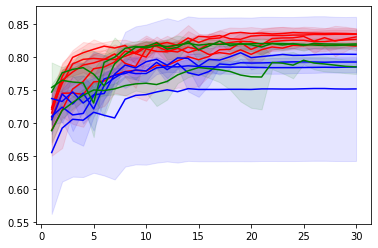

In [24]:
###########################################################################
####################### FCNN GRAPH ########################################
###########################################################################

stats = [[200  ,0.001  ,'r' , FCNN_image_specific] ,
         [500  ,0.001  ,'r' , FCNN_image_specific] ,
         [700  ,0.0007 ,'r' , FCNN_image_specific] ,
         [1000 ,0.0005 ,'r' , FCNN_image_specific] ,
         [1500 ,0.0002 ,'r' , FCNN_image_specific] ,
         
         [200 ,0.0004  ,'b', FCNN_1LAYER],
         [500 ,0.00025 ,'b', FCNN_1LAYER],
         [700 ,0.0004  ,'b', FCNN_1LAYER],
         [1000,0.00025 ,'b', FCNN_1LAYER],

         [ _ ,0.0001 ,'g', FCNN_2LAYER],
         [ _ ,0.0005 ,'g', FCNN_3LAYER],
         [ _ ,0.0005 ,'g', FCNN_4LAYER]
         
         ]

for el in stats:
  print(f'--- configuration : {el}')
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = train_multiple_runs( el[3] ,
                                                                                     runs = 5 ,
                                                                                     epoch = 30 ,
                                                                                     lr_= el[1] ,
                                                                                     criterion_ = F.binary_cross_entropy,
                                                                                     nodes_nb = el[0] )
  plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc , color = el[2])